### Лабораторна робота №2 - Вступ до напівкерованого навчання. Self-learning. Proxy Labelling. Noisy Student.

In [1]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device.type

'cuda'

1. Встановити сід генератору псевдовипадкових чисел;

In [2]:
torch.manual_seed(0)

if torch.cuda.is_available():
    torch.cuda.manual_seed(0)

2\. Завантажити обраний набір даних;<br>
4\. Розділити обраний набір даних на дві вибірки: тренувальну та валідаційну, співвідношення розміру вибірок обрати на власний розсуд. Після чого розділити тренувальний набір на дві частини марковану(30%) та немарковану(70%);


In [3]:
from torchvision import datasets
from torchvision.transforms import ToTensor


batch_size= 32

train_set = datasets.CIFAR10(root='../data', train=True,
                                        download=True, transform=ToTensor())
train_set, val_set = torch.utils.data.random_split(train_set, [0.8, 0.2])
train_set, unlabled_set = torch.utils.data.random_split(train_set, [0.3, 0.7])

test_set = datasets.CIFAR10(root='../data', train=False,
                                       download=True, transform=ToTensor())
print('train set:', len(train_set))
print('val set:', len(val_set))
print('unlabled set:', len(unlabled_set))
print('test set', len(test_set))

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
unlabled_loader = torch.utils.data.DataLoader(unlabled_set, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified
train set: 12000
val set: 10000
unlabled set: 28000
test set 10000


3. Відобразити декілька зображень з набору даних у блокноті;

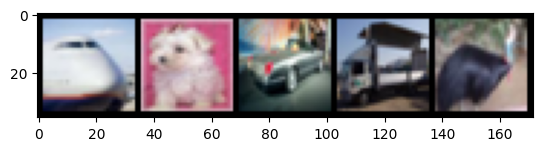

plane dog car truck bird


In [4]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision.utils


def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images[:5]))
print(' '.join(f'{classes[labels[j]]}' for j in range(5)))

In [5]:
from tqdm import tqdm

def train(model, tr_loader, vl_loader, optmzr, crtrn, num_epochs):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        progress_bar = tqdm(enumerate(tr_loader, 1), desc=f"Epoch {epoch+1}/{num_epochs}", leave=True, total=len(tr_loader))
        for step, (images, labels) in progress_bar:  
            images, labels = images.to(device), labels.to(device)
            
            optmzr.zero_grad()

            outputs = model(images)
            loss = crtrn(outputs, labels)
            loss.backward()
            optmzr.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

            progress_bar.set_postfix(loss=running_loss/(batch_size*(step+1)))

        train_loss = running_loss / len(tr_loader)
        train_accuracy = 100. * correct_train / total_train
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        
        running_loss = 0.0
        correct_val = 0
        total_val = 0
        model.eval()

        with torch.no_grad():
            for images, labels in vl_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = crtrn(outputs, labels)

                running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        val_loss = running_loss / len(vl_loader)
        val_accuracy = 100. * correct_val / total_val

        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        
        print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")
        print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")
    
    return train_losses, train_accuracies, val_losses, val_accuracies

In [6]:
def test(model, test_loader, criterion):
    running_loss = 0.0
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)


            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

    test_loss = running_loss / len(test_loader)
    test_accuracy = 100. * correct_test / total_test

    print('Test loss:', test_loss)
    print('Test accuracy:', test_accuracy)

    return test_loss, test_accuracy

5. Завантажити та налаштувати нейронну мережу обраної архітектури;
6. Провести навчання нейронної мережі **на початковому (до розділу на маркований і немаркований)** тренувальному наборі даних. Вибір гіперпараметрів на власний розсуд. Побудувати графіки точності та loss мережі під час навчання;

In [7]:
from torch import nn
from torchvision.models.vgg import VGG, make_layers
from torchvision.models.vgg import cfgs

config = cfgs['A']  # 'D' corresponds to VGG-16 configuration
features = make_layers(config)

superv_m = VGG(features, num_classes=len(classes)).to(device)

num_epochs = 20
learning_rate = 0.01

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(superv_m.parameters(), lr=learning_rate, weight_decay = 0.005, momentum = 0.9)

train_losses, train_accuracies, val_losses, val_accuracies = train(superv_m, train_loader, val_loader, optimizer, criterion, num_epochs)
superv_test_loss, superv_test_accuracy = test(superv_m, test_loader, criterion)

Epoch 1/20: 100%|██████████| 375/375 [00:07<00:00, 52.22it/s, loss=0.0682]


Train Loss: 2.1892, Train Accuracy: 17.12%
Validation Loss: 2.0313, Validation Accuracy: 24.66%


Epoch 2/20: 100%|██████████| 375/375 [00:08<00:00, 44.21it/s, loss=0.0602]


Train Loss: 1.9300, Train Accuracy: 26.76%
Validation Loss: 1.7831, Validation Accuracy: 31.42%


Epoch 3/20: 100%|██████████| 375/375 [00:08<00:00, 43.92it/s, loss=0.0536]


Train Loss: 1.7193, Train Accuracy: 35.17%
Validation Loss: 1.6028, Validation Accuracy: 39.45%


Epoch 4/20: 100%|██████████| 375/375 [00:08<00:00, 43.95it/s, loss=0.0502]


Train Loss: 1.6095, Train Accuracy: 39.61%
Validation Loss: 1.5437, Validation Accuracy: 42.37%


Epoch 5/20: 100%|██████████| 375/375 [00:06<00:00, 53.89it/s, loss=0.0472] 


Train Loss: 1.5145, Train Accuracy: 44.11%
Validation Loss: 1.5194, Validation Accuracy: 42.72%


Epoch 6/20: 100%|██████████| 375/375 [00:08<00:00, 43.88it/s, loss=0.045] 


Train Loss: 1.4435, Train Accuracy: 46.77%
Validation Loss: 1.4697, Validation Accuracy: 45.49%


Epoch 7/20: 100%|██████████| 375/375 [00:08<00:00, 43.81it/s, loss=0.0428]


Train Loss: 1.3729, Train Accuracy: 49.99%
Validation Loss: 1.4103, Validation Accuracy: 48.03%


Epoch 8/20: 100%|██████████| 375/375 [00:06<00:00, 54.32it/s, loss=0.0411] 


Train Loss: 1.3185, Train Accuracy: 51.83%
Validation Loss: 1.4770, Validation Accuracy: 48.12%


Epoch 9/20: 100%|██████████| 375/375 [00:08<00:00, 43.89it/s, loss=0.0398]


Train Loss: 1.2762, Train Accuracy: 53.77%
Validation Loss: 1.3606, Validation Accuracy: 50.79%


Epoch 10/20: 100%|██████████| 375/375 [00:08<00:00, 43.60it/s, loss=0.0373]


Train Loss: 1.1952, Train Accuracy: 56.95%
Validation Loss: 1.2954, Validation Accuracy: 52.77%


Epoch 11/20: 100%|██████████| 375/375 [00:06<00:00, 54.07it/s, loss=0.0354]


Train Loss: 1.1368, Train Accuracy: 59.11%
Validation Loss: 1.2377, Validation Accuracy: 55.35%


Epoch 12/20: 100%|██████████| 375/375 [00:08<00:00, 44.08it/s, loss=0.0349]


Train Loss: 1.1200, Train Accuracy: 59.70%
Validation Loss: 1.2290, Validation Accuracy: 55.67%


Epoch 13/20: 100%|██████████| 375/375 [00:08<00:00, 43.99it/s, loss=0.033] 


Train Loss: 1.0599, Train Accuracy: 61.97%
Validation Loss: 1.3515, Validation Accuracy: 53.09%


Epoch 14/20: 100%|██████████| 375/375 [00:08<00:00, 44.06it/s, loss=0.0318]


Train Loss: 1.0218, Train Accuracy: 63.79%
Validation Loss: 1.3790, Validation Accuracy: 53.16%


Epoch 15/20: 100%|██████████| 375/375 [00:06<00:00, 54.26it/s, loss=0.0304] 


Train Loss: 0.9738, Train Accuracy: 65.92%
Validation Loss: 1.2072, Validation Accuracy: 58.01%


Epoch 16/20: 100%|██████████| 375/375 [00:08<00:00, 44.11it/s, loss=0.0286]


Train Loss: 0.9167, Train Accuracy: 67.18%
Validation Loss: 1.1231, Validation Accuracy: 60.96%


Epoch 17/20: 100%|██████████| 375/375 [00:08<00:00, 43.97it/s, loss=0.0276]


Train Loss: 0.8868, Train Accuracy: 68.77%
Validation Loss: 1.2208, Validation Accuracy: 57.85%


Epoch 18/20: 100%|██████████| 375/375 [00:06<00:00, 54.15it/s, loss=0.027]  


Train Loss: 0.8671, Train Accuracy: 69.69%
Validation Loss: 1.2592, Validation Accuracy: 59.02%


Epoch 19/20: 100%|██████████| 375/375 [00:08<00:00, 44.04it/s, loss=0.0252]


Train Loss: 0.8075, Train Accuracy: 71.27%
Validation Loss: 1.2102, Validation Accuracy: 59.00%


Epoch 20/20: 100%|██████████| 375/375 [00:08<00:00, 44.03it/s, loss=0.0237]


Train Loss: 0.7589, Train Accuracy: 72.67%
Validation Loss: 1.1914, Validation Accuracy: 61.30%
Test loss: 1.2112610829523958
Test accuracy: 61.11


6.1 Побудувати графіки точності та loss мережі зі вчителем під час навчання

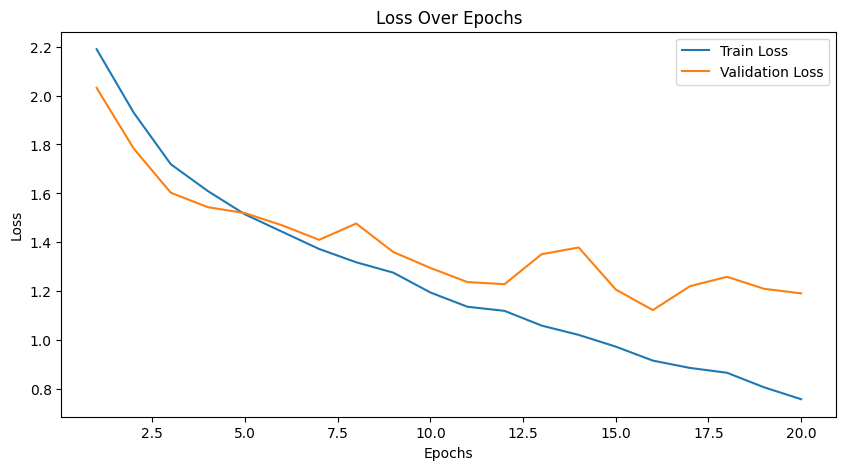

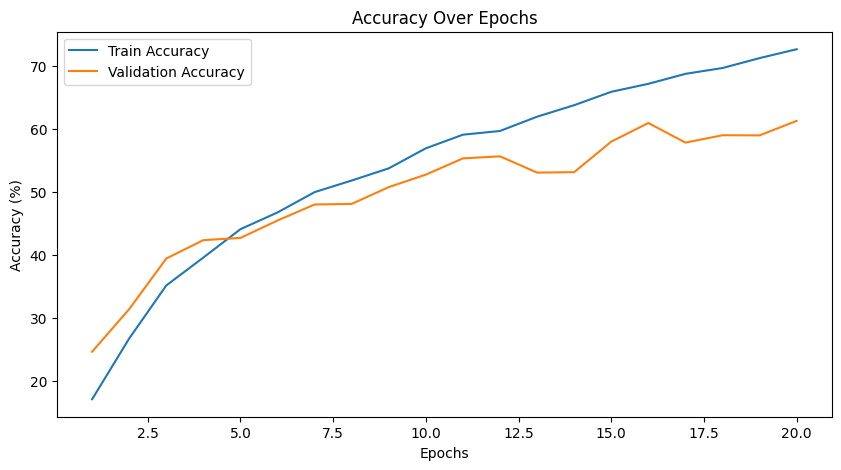

In [8]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()
plt.show()

# Plot Accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Over Epochs')
plt.legend()
plt.show()

7. Зберегти ваги навченої нейронної мережі у файл

In [9]:
torch.save(superv_m.state_dict(), '../models/lab2_supervised_model_weights.pth')

8. Керованою моделлю розмаркувати не марковані дані;

In [10]:
from torch.utils.data import TensorDataset

unlabled_images = []
pseudolabled_outputs = []
labled_outputs = []
superv_m.eval()
with torch.no_grad():
    for images, labels in unlabled_loader:
        images = images.to(device)
        
        outputs = superv_m(images)
        _, max_indices = torch.max(outputs, dim=1)

        unlabled_images.append(images)
        pseudolabled_outputs.append(max_indices)
        labled_outputs.append(labels)

pseudolabled_set = TensorDataset(torch.cat(unlabled_images, dim=0).cpu(), torch.cat(pseudolabled_outputs, dim=0).cpu())
pseudolabled_loader = torch.utils.data.DataLoader(pseudolabled_set, batch_size=batch_size, shuffle=True)

Lables in pseudolabled_loader and train_loader have different data types.

In [11]:
for batch_images, batch_labels in pseudolabled_loader.dataset:
    print(batch_images.shape, batch_labels)
    break

for batch_images, batch_labels in train_loader.dataset:
    print(batch_images.shape, batch_labels)
    break

torch.Size([3, 32, 32]) tensor(1)
torch.Size([3, 32, 32]) 7


Transform train_loader into tensored_train_loader

In [12]:
train_images = []
train_lables = []
for batch_images, batch_labels in train_loader:
    batch_images, batch_labels = batch_images.to(device), batch_labels.to(device)
        
    train_images.append(batch_images)
    train_lables.append(batch_labels)
tensored_train_set = TensorDataset(torch.cat(train_images, dim=0).cpu(), torch.cat(train_lables, dim=0).cpu())
tensored_train_loader = torch.utils.data.DataLoader(tensored_train_set, batch_size=batch_size, shuffle=True)

In [13]:
for batch_images, batch_labels in pseudolabled_loader.dataset:
    print(batch_images.shape, batch_labels)
    break

for batch_images, batch_labels in tensored_train_loader.dataset:
    print(batch_images.shape, batch_labels)
    break

torch.Size([3, 32, 32]) tensor(1)
torch.Size([3, 32, 32]) tensor(2)


8.1 Провести навчання нейронної мережі напівкерованим алгоритмом використовуючи маркований і немаркований набір даних на 4 кроці. Побудувати графіки точності та loss мережі під час навчання.

In [14]:
from torch.utils.data import ConcatDataset


combined_set = ConcatDataset([pseudolabled_loader.dataset, tensored_train_loader.dataset])
combined_loader = torch.utils.data.DataLoader(combined_set, batch_size=batch_size, shuffle=True)

config = cfgs['A']  # 'D' corresponds to VGG-16 configuration
features = make_layers(config)

self_trained_m = VGG(features, num_classes=len(classes)).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(self_trained_m.parameters(), lr=learning_rate, weight_decay = 0.005, momentum = 0.9)

train_losses, train_accuracies, val_losses, val_accuracies = train(self_trained_m, combined_loader, val_loader, optimizer, criterion, num_epochs)
self_trained_test_loss, self_trained_test_accuracy = test(self_trained_m, test_loader, criterion)

Epoch 1/20: 100%|██████████| 1250/1250 [00:25<00:00, 49.32it/s, loss=0.0631]


Train Loss: 2.0197, Train Accuracy: 23.82%
Validation Loss: 1.8921, Validation Accuracy: 31.13%


Epoch 2/20: 100%|██████████| 1250/1250 [00:25<00:00, 49.85it/s, loss=0.0467]


Train Loss: 1.4941, Train Accuracy: 44.58%
Validation Loss: 1.7591, Validation Accuracy: 41.42%


Epoch 3/20: 100%|██████████| 1250/1250 [00:25<00:00, 49.23it/s, loss=0.039] 


Train Loss: 1.2486, Train Accuracy: 55.26%
Validation Loss: 1.4728, Validation Accuracy: 46.53%


Epoch 4/20: 100%|██████████| 1250/1250 [00:25<00:00, 49.66it/s, loss=0.0336]


Train Loss: 1.0770, Train Accuracy: 61.98%
Validation Loss: 1.4082, Validation Accuracy: 53.44%


Epoch 5/20: 100%|██████████| 1250/1250 [00:25<00:00, 49.25it/s, loss=0.0308]


Train Loss: 0.9863, Train Accuracy: 65.41%
Validation Loss: 1.4056, Validation Accuracy: 54.66%


Epoch 6/20: 100%|██████████| 1250/1250 [00:25<00:00, 49.35it/s, loss=0.0294] 


Train Loss: 0.9409, Train Accuracy: 67.17%
Validation Loss: 1.3063, Validation Accuracy: 57.59%


Epoch 7/20: 100%|██████████| 1250/1250 [00:26<00:00, 46.68it/s, loss=0.0286]


Train Loss: 0.9146, Train Accuracy: 68.51%
Validation Loss: 1.3534, Validation Accuracy: 55.50%


Epoch 8/20: 100%|██████████| 1250/1250 [00:27<00:00, 46.17it/s, loss=0.0276]


Train Loss: 0.8849, Train Accuracy: 69.16%
Validation Loss: 1.3213, Validation Accuracy: 57.15%


Epoch 9/20: 100%|██████████| 1250/1250 [00:25<00:00, 49.29it/s, loss=0.0272]


Train Loss: 0.8697, Train Accuracy: 70.03%
Validation Loss: 1.3308, Validation Accuracy: 55.96%


Epoch 10/20: 100%|██████████| 1250/1250 [00:25<00:00, 49.80it/s, loss=0.0267]


Train Loss: 0.8548, Train Accuracy: 70.25%
Validation Loss: 1.2891, Validation Accuracy: 57.79%


Epoch 11/20: 100%|██████████| 1250/1250 [00:25<00:00, 49.86it/s, loss=0.0265]


Train Loss: 0.8493, Train Accuracy: 70.66%
Validation Loss: 1.1957, Validation Accuracy: 60.28%


Epoch 12/20: 100%|██████████| 1250/1250 [00:25<00:00, 49.41it/s, loss=0.0261]


Train Loss: 0.8375, Train Accuracy: 71.01%
Validation Loss: 1.2918, Validation Accuracy: 57.51%


Epoch 13/20: 100%|██████████| 1250/1250 [00:25<00:00, 49.06it/s, loss=0.026]  


Train Loss: 0.8314, Train Accuracy: 71.10%
Validation Loss: 1.3010, Validation Accuracy: 59.25%


Epoch 14/20: 100%|██████████| 1250/1250 [00:25<00:00, 48.99it/s, loss=0.0258] 


Train Loss: 0.8262, Train Accuracy: 71.49%
Validation Loss: 1.2433, Validation Accuracy: 59.26%


Epoch 15/20: 100%|██████████| 1250/1250 [00:27<00:00, 46.13it/s, loss=0.0254]


Train Loss: 0.8129, Train Accuracy: 72.08%
Validation Loss: 1.3147, Validation Accuracy: 59.02%


Epoch 16/20: 100%|██████████| 1250/1250 [00:27<00:00, 45.91it/s, loss=0.0261]


Train Loss: 0.8344, Train Accuracy: 70.79%
Validation Loss: 1.2888, Validation Accuracy: 58.99%


Epoch 17/20: 100%|██████████| 1250/1250 [00:25<00:00, 49.13it/s, loss=0.0253]


Train Loss: 0.8087, Train Accuracy: 71.98%
Validation Loss: 1.3342, Validation Accuracy: 57.69%


Epoch 18/20: 100%|██████████| 1250/1250 [00:25<00:00, 49.00it/s, loss=0.025] 


Train Loss: 0.8018, Train Accuracy: 72.06%
Validation Loss: 1.4327, Validation Accuracy: 54.59%


Epoch 19/20: 100%|██████████| 1250/1250 [00:25<00:00, 49.25it/s, loss=0.0253]


Train Loss: 0.8093, Train Accuracy: 72.05%
Validation Loss: 1.3291, Validation Accuracy: 59.23%


Epoch 20/20: 100%|██████████| 1250/1250 [00:25<00:00, 49.47it/s, loss=0.0251]


Train Loss: 0.8051, Train Accuracy: 71.97%
Validation Loss: 1.2942, Validation Accuracy: 57.72%
Test loss: 1.299451787060442
Test accuracy: 57.49


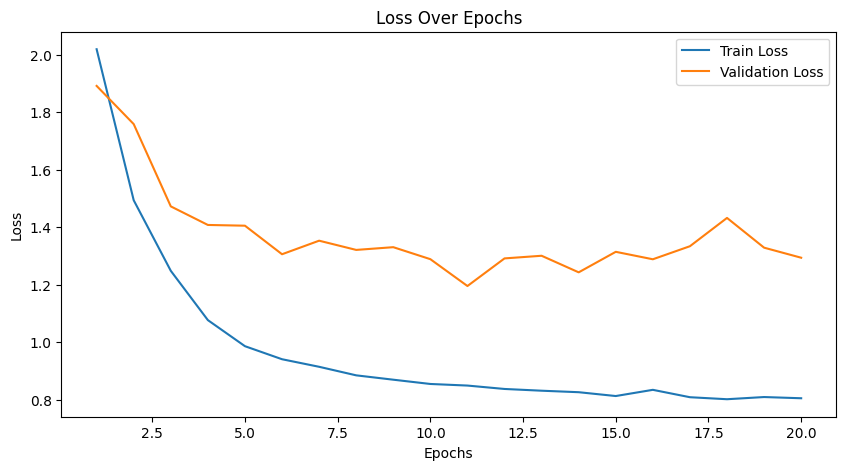

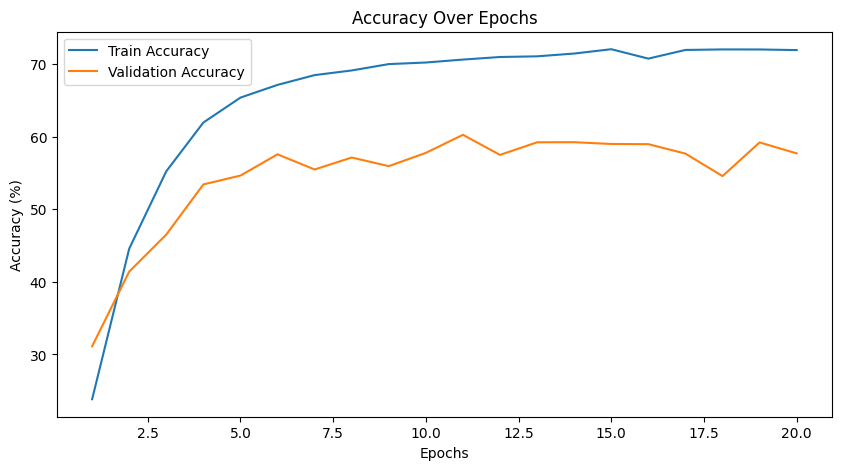

In [15]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()
plt.show()

# Plot Accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Over Epochs')
plt.legend()
plt.show()

9. Зберегти ваги навченої нейронної мережі у файл;

In [16]:
torch.save(superv_m.state_dict(), '../models/lab2_self_trained_model_weights.pth')

10. Зробити висновки, оформити звіт.

In [17]:
print('supervised test loss:', superv_test_loss)
print('supervised accuracy:', superv_test_accuracy)
print('self-trained test loss:', self_trained_test_loss)
print('self-trained accuracy:', self_trained_test_accuracy)

supervised test loss: 1.2112610829523958
supervised accuracy: 61.11
self-trained test loss: 1.299451787060442
self-trained accuracy: 57.49
